# k-NN Project 1: `iris` Classification

This data is from `sklearn.datasets`. This dataset consists of 3 different types of irises' petal / sepal length / width, stored in a $150\times4$ `numpy.ndarray`. We already explored the dataset briefly in the previous chapter. This time we will try to use the feature provided to predict the type of the irises. For the purpose of plotting, we will only use the first two features: `sepal length` and `sepal width`.

## Explore the dataset
We first load the dataset. 


In [42]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

Then we would like to split the dataset into trainning data and test data. Here we are going to use `sklearn.model_selection.train_test_split` function. Besides the dataset, we should also provide the propotion of the test set comparing to the whole dataset. We will choose `test_size=0.1` here, which means that the size of the test set is 0.1 times the size of the whole dataset. `stratify=y` means that when split the dataset we want to split respects the distribution of labels in `y`. 

The split will be randomly. You may set the argument `random_state` to be a certain number to control the random process. If you set a `random_state`, the result of the random process will stay the same. This is for reproducible output across multiple function calls.


After we get the training set, we should also normalize it. All our normalization should be based on the training set. When we want to use our model on some new data points, we will use the same normalization parameters to normalize the data points in interests right before we apply the model. Here since we mainly care about the test set, we could normalize the test set at this stage.

Note that in the following code, I import functions `encodeNorm` from `assests.codes.knn`. You need to modify this part based on your file structure. See [here](section:applyourknn) for more details.

In [43]:
from sklearn.model_selection import train_test_split
from assests.codes.knn import encodeNorm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

X_train_norm, parameters = encodeNorm(X_train)
X_test_norm, _ = encodeNorm(X_test, parameters=parameters)

Before we start to play with k-NN, let us look at the data first. Since we only choose two features, it is able to plot these data points on a 2D plane, with different colors representing different classes. 


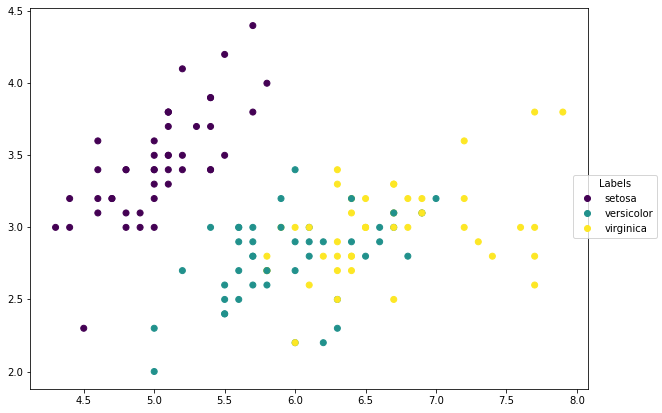

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the scatter plot.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# Generate legends.
labels = ['setosa', 'versicolor', 'virginica']
fig.legend(handles=scatter.legend_elements()[0], labels=labels,
           loc="right", title="Labels")

plt.show()

(section:applyourknn)=
## Apply our k-NN model 

Now let us apply k-NN to this dataset. We first use our codes. Here I use `from assests.codes.knn` to import our functions since I put all our functions in `./assests/codes/knn.py`. Then the poential code is 
```python
y_pred = classify_kNN(X_test, X_train, y_train, k=10)
```

Note that the above code is actually wrong. The issue ist that our function `classify_kNN` can only classify one row of data. To classify many rows, we need to use a `for` loop. 


In [45]:
from assests.codes.knn import classify_kNN

n_neighbors = 10
y_pred = list()
for row in X_test_norm:
    row_pred = classify_kNN(row, X_train_norm, y_train, k=n_neighbors)
    y_pred.append(row_pred)
y_pred = np.array(y_pred)

We could use list comprehension to simply the above codes. 

In [46]:
from assests.codes.knn import classify_kNN

n_neighbors = 10
y_pred = np.array([classify_kNN(row, X_train_norm, y_train, k=n_neighbors)
                   for row in X_test_norm])

This `y_pred` is the result we got for the test set. We may compare it with the real answer `y_test`, and calcuate the accuracy.

In [47]:
acc = np.mean(y_pred == y_test)
print(acc)


0.7333333333333333


## Apply k-NN model from `sklearn`

Now we would like to use `sklearn` to reproduce this result. Since our data is prepared, what we need to do is directly call the functions.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 10
clf = KNeighborsClassifier(n_neighbors, weights="uniform", metric="euclidean",
                           algorithm='brute')
clf.fit(X_train_norm, y_train)
y_pred_sk = clf.predict(X_test_norm)

acc = np.mean(y_pred_sk == y_test)
print(acc)

0.7333333333333333


## Using data pipeline
We may organize the above process in a neater way. After we get a data, the usual process is to apply several transforms to the data before we really get to the model part. Using terminolgies from `sklearn`, the former are called *transforms*, and the latter is called an *estimator*. In this example, we have exactly one tranform which is the normalization. The estimator here we use is the k-NN classifier. 

`sklearn` provides a standard way to write these codes, which is called `pipeline`. We may chain the transforms and estimators in a sequence and let the data go through the pipeline. In this example, the pipeline contains two steps:
1. The normalization transform `sklearn.preprocessing.MinMaxScaler`. When we directly apply it the parameters `ranges` and `minVals` and  will be recorded automatically, and we don't need to worry about it when we want to use the same parameters to normalize other data.
2. The k-NN classifier `sklearn.neighbors.KNeighborsClassifier`. This is the same one as we use previously.

The code is as follows. It is a straightforward code. Note that the `()` after the class in each step of `steps` is very important. The codes cannot run if you miss it.

After we setup the pipeline, we may use it as other estimators since it is an estimator. Here we may also use the accuracy function provided by `sklearn` to perform the computation. It is essentially the same as our `acc` computation.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

steps = [('scaler', MinMaxScaler()),
         ('knn', KNeighborsClassifier(n_neighbors, weights="uniform",
                                      metric="euclidean", algorithm='brute'))]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
y_pipe = pipe.predict(X_test)
print(accuracy_score(y_pipe, y_test))

0.7333333333333333


## Visualize the Decision boundary
Using the classifier we get above, we are able to classify every points on the plane. This enables us to draw the following plot, which is called the Decision boundary. It helps us to visualize the relations between features and the classes.

We use `DecisionBoundaryDisplay` from `sklearn.inspection` to plot the decision boundary. The function requires us to have a fitted classifier. We may use the classifier `pipe` we got above. Note that this classifier should have some build-in structures that our `classify_kNN` function doesn't have. We may rewrite our codes to make it work, but this goes out of the scope of this section. This is supposed to be Python programming exercise. We will talk about it in the future if we have enough time.

We first plot the dicision boundary using `DecisionBoundaryDisplay.from_estimator`. Then we plot the points from `X_test`. From the plot it is very clear which points are misclassified.

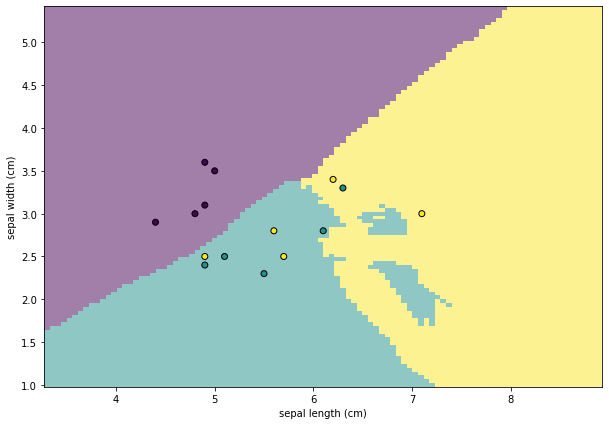

In [50]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
            pipe, 
            X_train,
            response_method="predict",
            plot_method="pcolormesh",
            xlabel=iris.feature_names[0],
            ylabel=iris.feature_names[1],
            alpha=0.5)
disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="k")
disp.figure_.set_size_inches((10,7))

(section-cross-validation)=
## k-Fold Cross-Validation

Previously we perform a random split and test our model in this case. What would happen if we fit our model on another split? We might get a different accuracy score. So in order to evaluate the performance of our model, it is natual to consider several different split and compute the accuracy socre for each case, and combine all these socres together to generate an index to indicate whehter our model is good or bad. This naive idea is called *k-Fold Cross-Validation*.

The algorithm is described as follows. We first randomly split the dataset into `k` groups. We use one of them as the test set, and the rest together forming the training set, and use this setting to get an accuracy score. We did this for each group to be chosen as the test set. Then the final score is the mean.

`sklearn` provides a function `sklearn.model_selection.cross_val_score` to perform the above computation. The usage is straightforward, as follows.

In [51]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipe, X, y, cv=5)
print(cv_scores)
print(np.mean(cv_scores))

[0.66666667 0.8        0.63333333 0.8        0.7       ]
0.7200000000000001


## Choosing a `k` value
In the previous example we choose `k` to be `10` as an example. To choose a `k` value we usually run some test by trying different `k` and choose the one with the best performance. In this case, best performance means the highest cross-validation score.

`sklearn.model_selection.GridSearchCV` provides a way to do this directly. We only need to setup the esitimator, the metric (which is the cross-validation score in this case), and the hyperparameters to be searched through, and `GridSearchCV` will run the search automatically.

We let `k` go from `1` to `100`. The code is as follows.

Note that `parameters` is where we set the search space. It is a dictionary. The key is the name of the estimator plus double `_` and then plus the name of the parameter. 

In [52]:
from sklearn.model_selection import GridSearchCV
n_list = list(range(1, 101))
parameters = dict(knn__n_neighbors=n_list)
clf = GridSearchCV(pipe, parameters)
clf.fit(X, y)
print(clf.best_estimator_.get_params()["knn__n_neighbors"])

31


After we fit the data, the `best_estimator_.get_params()` can be printed. It tells us that it is best to use `31` neibhours for our model. We can directly use the best estimator by calling `clf.best_estimator_`.

In [53]:
cv_scores = cross_val_score(clf.best_estimator_, X, y, cv=5)
print(np.mean(cv_scores))

0.8200000000000001


The cross-validation score using `k=31` is calculated. This serves as a benchmark score and we may come back to dataset using other methods and compare the scores.